In [1]:
# BLOCCO 1: Confronto Attributi Dataset Zeek
# Controllo e uniformazione colonne tra UWF-ZeekData22 e UWF-ZeekDataFall22

import os
import pandas as pd

# ------------- Blocchi 1 e 2: Definizione dei percorsi -------------
# Blocco 1: Cartella ZeekData22
folder_data22 = r"C:\Users\maria\Desktop\Zeek_ML\UWF-ZeekData22"

# Blocco 2: Cartella ZeekDataFall22
folder_datafall22 = r"C:\Users\maria\Desktop\Zeek_ML\UWF-ZeekDataFall22"

# Funzione per caricare tutti i parquet e csv di una cartella in un unico DataFrame
def load_dataset(folder_path):
    all_files = os.listdir(folder_path)
    dfs = []
    for f in all_files:
        path = os.path.join(folder_path, f)
        if f.endswith(".parquet"):
            dfs.append(pd.read_parquet(path))
        elif f.endswith(".csv"):
            dfs.append(pd.read_csv(path))
    if dfs:
        # Concateno tutto in un unico dataframe
        combined_df = pd.concat(dfs, ignore_index=True)
        return combined_df
    else:
        return pd.DataFrame()

# ------------- Blocco 3: Caricamento dataset -------------
df_22 = load_dataset(folder_data22)
df_fall22 = load_dataset(folder_datafall22)

# ------------- Blocco 4: Controllo colonne -------------
cols_22 = set(df_22.columns)
cols_fall22 = set(df_fall22.columns)

# Colonne uniche per ciascun dataset
unique_22 = cols_22 - cols_fall22
unique_fall22 = cols_fall22 - cols_22
common_cols = cols_22 & cols_fall22

# ------------- Blocco 5: Stampa report differenze -------------
print("=== BLOCCO 5: Report differenze tra dataset ===\n")
print(f"Totale colonne in ZeekData22: {len(cols_22)}")
print(f"Totale colonne in ZeekDataFall22: {len(cols_fall22)}\n")

print("Colonne presenti solo in ZeekData22:")
for col in sorted(unique_22):
    print(f"  - {col}")
print("\nColonne presenti solo in ZeekDataFall22:")
for col in sorted(unique_fall22):
    print(f"  - {col}")
print("\nColonne comuni a entrambi i dataset:")
for col in sorted(common_cols):
    print(f"  - {col}")


=== BLOCCO 5: Report differenze tra dataset ===

Totale colonne in ZeekData22: 37
Totale colonne in ZeekDataFall22: 38

Colonne presenti solo in ZeekData22:
  - 2022-01-09 - 2022-01-16
  - 2022-01-16 - 2022-01-23
  - 2022-02-06 - 2022-02-13
  - 2022-02-13 - 2022-02-20
  - dest_ip
  - dest_port
  - mitre_attack_tactics
  - protocol
  - src_ip
  - src_port

Colonne presenti solo in ZeekDataFall22:
  - 2022-08-28 - 2022-09-04
  - 2022-09-04 - 2022-09-11
  - 2022-09-11 - 2022-09-18
  - 2022-09-18 - 2022-09-25
  - 2022-09-25 - 2022-10-02
  - 2022-10-02 - 2022-10-09
  - 2022-10-09 - 2022-10-16
  - 2022-10-16 - 2022-10-23
  - 2022-10-23 - 2022-10-30
  - label_binary
  - label_technique

Colonne comuni a entrambi i dataset:
  - 2021-12-12 - 2021-12-19
  - 2021-12-19 - 2021-12-26
  - 2021-12-26 - 2022-01-02
  - 2022-01-02 - 2022-01-09
  - community_id
  - conn_state
  - datetime
  - dest_ip_zeek
  - dest_port_zeek
  - duration
  - history
  - label_tactic
  - local_orig
  - local_resp
  - misse

In [2]:
# BLOCCO 1: Data Cleaning su ZeekDataFall22
# Scopo:
# 1. Rimuovere duplicati: log di connessioni identici possono alterare l'addestramento
# 2. Imputare valori mancanti: evitare errori negli algoritmi ML e ridurre bias
# 3. Aggregazioni (session-level features): combinare più record di connessione in metriche significative
#    come totale pacchetti per sessione o durata media, per rendere il modello più robusto

import os
import pandas as pd
import glob
from tqdm import tqdm

# Percorso cartella contenente i file parquet
folder_path = r"C:\Users\maria\Desktop\Zeek_ML\UWF-ZeekDataFall22"
parquet_files = glob.glob(os.path.join(folder_path, "*.parquet"))

# Caricamento dati in un unico DataFrame
dfs = []
for file in tqdm(parquet_files, desc="Caricamento file parquet"):
    dfs.append(pd.read_parquet(file))

data = pd.concat(dfs, ignore_index=True)
print(f"Totale righe prima del cleaning: {len(data)}")
print(f"Totale colonne: {data.shape[1]}")

# ==========================
# 1. Rimozione duplicati
# ==========================
duplicates_before = data.duplicated().sum()
data = data.drop_duplicates()
duplicates_after = data.duplicated().sum()
print(f"Duplicati trovati e rimossi: {duplicates_before - duplicates_after}")

# ==========================
# 2. Imputazione valori mancanti
# ==========================
# Strategia: 
# - numeriche → media
# - categoriali → moda
num_cols = data.select_dtypes(include=['int64','float64']).columns
cat_cols = data.select_dtypes(include=['object','category']).columns

imputation_count = 0

for col in num_cols:
    missing = data[col].isna().sum()
    if missing > 0:
        data[col].fillna(data[col].mean(), inplace=True)
        imputation_count += missing

for col in cat_cols:
    missing = data[col].isna().sum()
    if missing > 0:
        data[col].fillna(data[col].mode()[0], inplace=True)
        imputation_count += missing

print(f"Totale valori imputati: {imputation_count}")

# ==========================
# 3. Aggregazioni (session-level features)
# ==========================
# Spiegazione:
# - Le connessioni multiple tra gli stessi host possono essere aggregate in sessioni
# - Feature utili: totale pacchetti, byte totali, durata media
# - Questo permette al modello di avere una visione più globale del comportamento di rete
# - Qui consideriamo 'uid' come identificativo della sessione

session_features = data.groupby('uid').agg(
    total_orig_bytes=('orig_bytes', 'sum'),
    total_resp_bytes=('resp_bytes', 'sum'),
    total_orig_pkts=('orig_pkts', 'sum'),
    total_resp_pkts=('resp_pkts', 'sum'),
    mean_duration=('duration', 'mean')
).reset_index()

print(f"Totale sessioni aggregate: {session_features.shape[0]}")

# Unione delle aggregazioni col dataframe originale per eventuali altre feature
data = pd.merge(data, session_features, on='uid', how='left')

# Mostriamo le prime righe del dataframe pulito
print("Prime righe del dataset dopo cleaning e aggregazioni:")
display(data.head())


Caricamento file parquet: 100%|██████████| 13/13 [00:01<00:00, 10.97it/s]


Totale righe prima del cleaning: 700340
Totale colonne: 25
Duplicati trovati e rimossi: 16745
Totale valori imputati: 1219118
Totale sessioni aggregate: 660373
Prime righe del dataset dopo cleaning e aggregazioni:


,community_id,conn_state,duration,history,src_ip_zeek,src_port_zeek,dest_ip_zeek,dest_port_zeek,local_orig,local_resp,...,uid,datetime,label_tactic,label_technique,label_binary,total_orig_bytes,total_resp_bytes,total_orig_pkts,total_resp_pkts,mean_duration
0,1:ktX8uiwrFpzrBHnE1G51yTAiiQo=,S1,41.878964,ShAdD,143.88.10.11,42296,143.88.10.13,9999,False,False,...,CrA3emsiAM5XvugO6,2022-10-23 22:07:45.793,Persistence,T1546,True,44.0,7388.0,28,20,41.878964
1,1:ktX8uiwrFpzrBHnE1G51yTAiiQo=,S1,41.878964,ShAdD,143.88.10.11,42296,143.88.10.13,9999,False,False,...,CrA3emsiAM5XvugO6,2022-10-23 22:07:45.793,Privilege Escalation,Duplicate,Duplicate,44.0,7388.0,28,20,41.878964
2,1:ktX8uiwrFpzrBHnE1G51yTAiiQo=,S1,41.878964,ShAdD,143.88.10.11,42296,143.88.10.13,9999,False,False,...,CrA3emsiAM5XvugO6,2022-10-23 22:07:45.793,Defense Evasion,T1112,True,44.0,7388.0,28,20,41.878964
3,1:ktX8uiwrFpzrBHnE1G51yTAiiQo=,S1,41.878964,ShAdD,143.88.10.11,42296,143.88.10.13,9999,False,False,...,CrA3emsiAM5XvugO6,2022-10-23 22:07:45.793,Persistence,T1547,True,44.0,7388.0,28,20,41.878964
4,1:52yAKDtnHSPDIljwNPlA+UWODdA=,SF,0.041849,ShAdDFaf,143.88.10.11,57042,143.88.10.16,9999,False,False,...,CqO92B3QWHYhyPdtse,2022-10-05 18:14:34.531,Execution,T1059,True,114.0,73.0,9,6,0.041849


In [5]:
# BLOCCO 2: Controllo valori nulli e riepilogo colonne/feature

# Controllo valori nulli residui
null_counts = data.isna().sum()
null_cols = null_counts[null_counts > 0]

if len(null_cols) == 0:
    print("✅ Non ci sono valori nulli residui.")
else:
    print("⚠️ Colonne con valori nulli residui:")
    display(null_cols)

# Riepilogo colonne e feature rimaste dopo data cleaning e aggregazioni
print("\n📊 Colonne e feature disponibili per l'analisi:")
for i, col in enumerate(data.columns):
    print(f"{i+1}. {col}")

# Opzionale: possiamo separare feature numeriche e categoriali per la fase successiva
num_features = data.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = data.select_dtypes(include=['object','category']).columns.tolist()

print("\n🔹 Feature numeriche:")
print(num_features)
print("\n🔹 Feature categoriali:")
print(cat_features)


✅ Non ci sono valori nulli residui.

📊 Colonne e feature disponibili per l'analisi:
1. community_id
2. conn_state
3. duration
4. history
5. src_ip_zeek
6. src_port_zeek
7. dest_ip_zeek
8. dest_port_zeek
9. local_orig
10. local_resp
11. missed_bytes
12. orig_bytes
13. orig_ip_bytes
14. orig_pkts
15. proto
16. resp_bytes
17. resp_ip_bytes
18. resp_pkts
19. service
20. ts
21. uid
22. datetime
23. label_tactic
24. label_technique
25. label_binary
26. total_orig_bytes
27. total_resp_bytes
28. total_orig_pkts
29. total_resp_pkts
30. mean_duration

🔹 Feature numeriche:
['duration', 'src_port_zeek', 'dest_port_zeek', 'missed_bytes', 'orig_bytes', 'orig_ip_bytes', 'orig_pkts', 'resp_bytes', 'resp_ip_bytes', 'resp_pkts', 'ts', 'total_orig_bytes', 'total_resp_bytes', 'total_orig_pkts', 'total_resp_pkts', 'mean_duration']

🔹 Feature categoriali:
['community_id', 'conn_state', 'history', 'src_ip_zeek', 'dest_ip_zeek', 'proto', 'service', 'uid', 'label_tactic', 'label_technique', 'label_binary']


⚠️ Numero di valori non convertibili in label_binary: 0
✅ label_binary pronta per l'analisi numerica.

🔹 Feature numeriche candidate: ['duration', 'src_port_zeek', 'dest_port_zeek', 'missed_bytes', 'orig_bytes', 'orig_ip_bytes', 'orig_pkts', 'resp_bytes', 'resp_ip_bytes', 'resp_pkts', 'ts', 'total_orig_bytes', 'total_resp_bytes', 'total_orig_pkts', 'total_resp_pkts', 'mean_duration']

📊 Varianza delle feature numeriche:


ts                  1.295013e+14
dest_port_zeek      3.134979e+08
resp_ip_bytes       1.402955e+08
total_resp_bytes    6.494168e+07
resp_bytes          6.448282e+07
src_port_zeek       5.233061e+07
orig_ip_bytes       5.541909e+06
total_orig_bytes    1.143618e+06
orig_bytes          7.722799e+05
missed_bytes        1.626861e+03
total_resp_pkts     7.448543e+02
total_orig_pkts     7.383744e+02
resp_pkts           6.254423e+02
orig_pkts           6.197323e+02
duration            6.587325e+01
mean_duration       6.587325e+01
dtype: float64


✅ Feature con varianza significativa: ['ts', 'dest_port_zeek', 'resp_ip_bytes', 'total_resp_bytes', 'resp_bytes', 'src_port_zeek', 'orig_ip_bytes', 'total_orig_bytes', 'orig_bytes', 'missed_bytes', 'total_resp_pkts', 'total_orig_pkts', 'resp_pkts', 'orig_pkts', 'duration', 'mean_duration']
📝 Criterio: distinguono le osservazioni e aiutano il modello.

📊 Correlazione con label_binary (valori assoluti ordinati):


ts                  0.998725
dest_port_zeek      0.666646
src_port_zeek       0.134258
total_orig_bytes    0.024605
orig_ip_bytes      -0.019945
orig_pkts          -0.016214
orig_bytes          0.014011
total_resp_pkts     0.013876
duration           -0.010899
mean_duration      -0.010899
total_resp_bytes    0.006724
resp_bytes          0.004006
total_orig_pkts    -0.002984
missed_bytes       -0.002811
resp_pkts           0.002509
resp_ip_bytes      -0.001920
dtype: float64


✅ Feature selezionate (varianza + correlazione): ['ts', 'dest_port_zeek', 'src_port_zeek']
📝 Criterio: feature correlate alla label forniscono informazione utile e riducono rumore.

⚠️ Numero di outlier trovati per feature:


ts                0
dest_port_zeek    0
src_port_zeek     0
dtype: int64


📌 Esempi di outlier (primi 5 per feature):
ts: []
dest_port_zeek: []
src_port_zeek: []

📝 Criterio: non rimuoviamo outlier subito perché possono rappresentare sessioni lunghe o attacchi rari. Li flagghiamo per eventuali trasformazioni (log, clipping o Winsorization) nella fase di scaling.



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


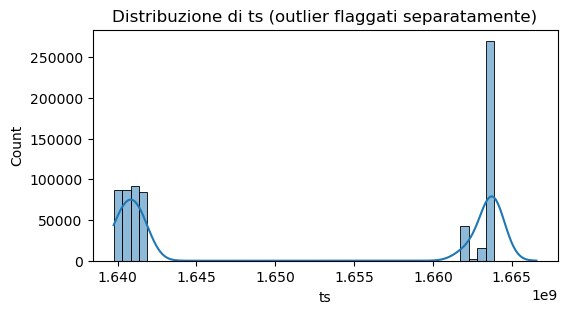

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


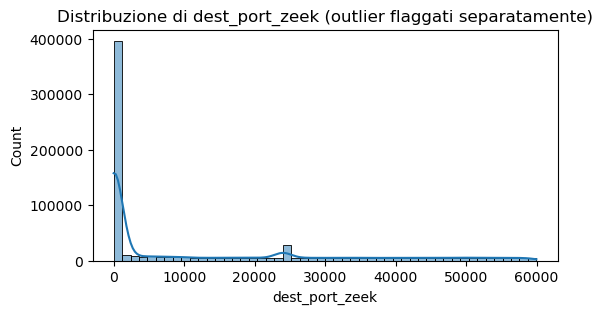

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


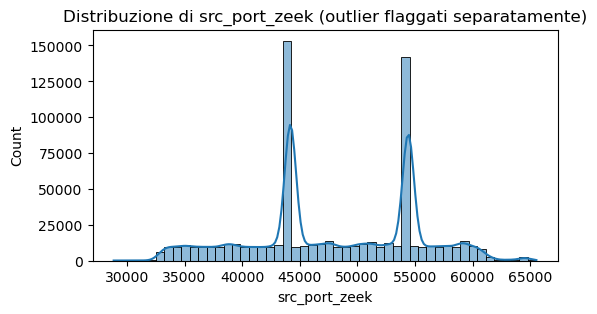


📌 Feature numeriche finali pronte per scaling/normalizzazione: ['ts', 'dest_port_zeek', 'src_port_zeek']
📝 Scaling/normalizzazione necessario per garantire peso uniforme delle feature nei modelli ML e stabilità nella convergenza.


In [10]:
# BLOCCO 3b: Analisi feature numeriche e gestione outlier separata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================================
# Step 0: Pulizia sicura della label_binary
# ==============================================
# Alcuni valori in label_binary non sono True/False (es. 'Duplicate'), quindi li mappiamo a 1/0
# Altri valori non convertibili diventano NaN e vengono rimossi
data['label_binary_clean'] = data['label_binary'].map({
    True: 1, False: 0, 'True': 1, 'False': 0, 1: 1, 0: 0
})
invalid_labels = data['label_binary_clean'].isna().sum()
print(f"⚠️ Numero di valori non convertibili in label_binary: {invalid_labels}")

# Eliminazione righe con label non convertibili
data = data.dropna(subset=['label_binary_clean'])
data['label_binary'] = data['label_binary_clean'].astype(int)
data = data.drop(columns=['label_binary_clean'])
print("✅ label_binary pronta per l'analisi numerica.\n")

# ==============================================
# Step 1: Identificazione feature numeriche candidate
# ==============================================
num_features = data.select_dtypes(include=['int64','float64']).columns.tolist()
# Rimuoviamo eventuali label numeriche dalla lista delle feature
for col in ['label_binary','label_technique']:
    if col in num_features:
        num_features.remove(col)

print(f"🔹 Feature numeriche candidate: {num_features}\n")

# ==============================================
# Step 2: Analisi varianza e correlazione con label
# ==============================================
# 1️⃣ Varianza: feature quasi costanti non informative
variance = data[num_features].var().sort_values(ascending=False)
print("📊 Varianza delle feature numeriche:")
display(variance)

var_threshold = 0.01
selected_features = variance[variance > var_threshold].index.tolist()
print(f"\n✅ Feature con varianza significativa: {selected_features}")
print("📝 Criterio: distinguono le osservazioni e aiutano il modello.\n")

# 2️⃣ Correlazione con label_binary
corr_with_label = data[selected_features].corrwith(data['label_binary']).sort_values(key=abs, ascending=False)
print("📊 Correlazione con label_binary (valori assoluti ordinati):")
display(corr_with_label)

corr_threshold = 0.05
final_features = corr_with_label[abs(corr_with_label) > corr_threshold].index.tolist()
print(f"\n✅ Feature selezionate (varianza + correlazione): {final_features}")
print("📝 Criterio: feature correlate alla label forniscono informazione utile e riducono rumore.\n")

# ==============================================
# Step 3: Analisi outlier separata
# ==============================================
# Non eliminiamo direttamente i campioni: analizziamo e decidiamo come gestire outlier
outlier_summary = {}
outlier_examples = {}

for col in final_features:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = data[(data[col] < lower) | (data[col] > upper)]
    outlier_summary[col] = len(outliers)
    outlier_examples[col] = outliers[col].head(5).tolist()
    
    # Flag outlier senza rimuovere (utile per analisi o trasformazioni future)
    data[f'{col}_outlier'] = ((data[col] < lower) | (data[col] > upper)).astype(int)

print("⚠️ Numero di outlier trovati per feature:")
display(pd.Series(outlier_summary))

print("\n📌 Esempi di outlier (primi 5 per feature):")
for col, examples in outlier_examples.items():
    print(f"{col}: {examples}")

print("\n📝 Criterio: non rimuoviamo outlier subito perché possono rappresentare sessioni lunghe o attacchi rari. Li flagghiamo per eventuali trasformazioni (log, clipping o Winsorization) nella fase di scaling.\n")

# ==============================================
# Step 4: Visualizzazione distribuzioni finali
# ==============================================
for col in final_features:
    plt.figure(figsize=(6,3))
    sns.histplot(data[col], bins=50, kde=True)
    plt.title(f'Distribuzione di {col} (outlier flaggati separatamente)')
    plt.show()

# ==============================================
# Step 5: Preparazione lista feature numeriche per scaling
# ==============================================
numeric_for_scaling = final_features
print(f"\n📌 Feature numeriche finali pronte per scaling/normalizzazione: {numeric_for_scaling}")
print("📝 Scaling/normalizzazione necessario per garantire peso uniforme delle feature nei modelli ML e stabilità nella convergenza.")


📊 Analisi della distribuzione delle classi dopo data cleaning:

🔹 Distribuzione label_binary (0 = benigno, 1 = attacco):


,Conteggio,Percentuale (%)
label_binary,,
0,350339,51.47
1,330357,48.53


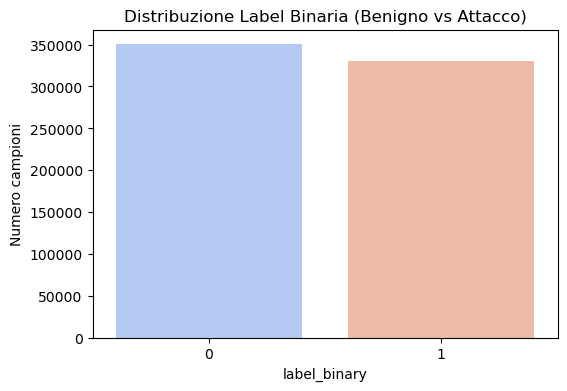


🔹 Distribuzione per categoria di attacco (label_technique):


,Conteggio,Percentuale (%)
label_technique,,
none,350339,51.47
T1587,262409,38.55
T1592,20382,2.99
T1590,20183,2.97
T1046,16025,2.35
T1595,8104,1.19
T1548,2893,0.43
T1589,278,0.04
T1203,18,0.00


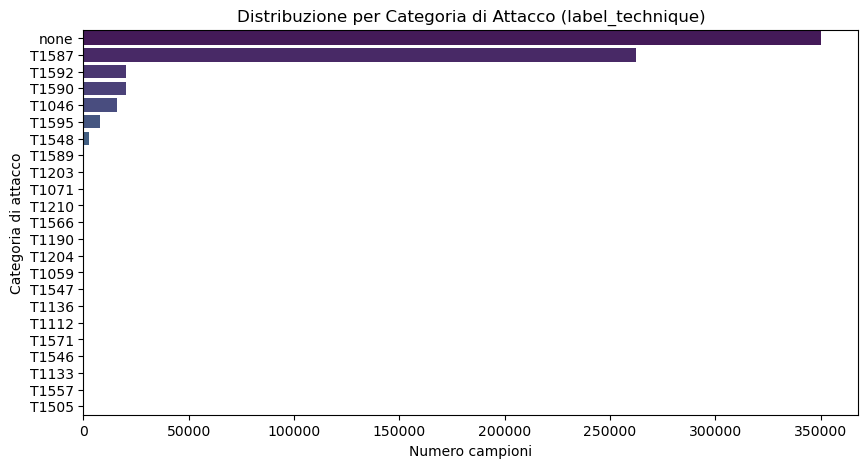


📝 Interpretazione:
- Questa analisi serve a valutare l’equilibrio delle classi dopo le operazioni di cleaning e outlier handling.
- Se alcune categorie risultano fortemente sbilanciate, potrà essere necessario applicare tecniche di bilanciamento (SMOTE, undersampling, pesi di classe) in fase di training.
- La verifica della distribuzione è anche utile per confrontare la coerenza del dataset di training (ZeekDataFall22) con quello di test (ZeekData22).


In [11]:
# ==========================================================
# BLOCCO 3c: Analisi distribuzione delle classi post-cleaning
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("📊 Analisi della distribuzione delle classi dopo data cleaning:\n")

# ======================================================
# Step 1: Distribuzione label binaria (benigno vs attacco)
# ======================================================
binary_counts = data['label_binary'].value_counts().sort_index()
binary_percent = (binary_counts / len(data) * 100).round(2)

binary_df = pd.DataFrame({
    'Conteggio': binary_counts,
    'Percentuale (%)': binary_percent
})
print("🔹 Distribuzione label_binary (0 = benigno, 1 = attacco):")
display(binary_df)

plt.figure(figsize=(6,4))
sns.barplot(x=binary_counts.index, y=binary_counts.values, palette='coolwarm')
plt.title("Distribuzione Label Binaria (Benigno vs Attacco)")
plt.xlabel("label_binary")
plt.ylabel("Numero campioni")
plt.show()

# ======================================================
# Step 2: Distribuzione per categoria di attacco
# ======================================================
if 'label_technique' in data.columns:
    attack_counts = data['label_technique'].value_counts()
    attack_percent = (attack_counts / len(data) * 100).round(2)

    attack_df = pd.DataFrame({
        'Conteggio': attack_counts,
        'Percentuale (%)': attack_percent
    })
    print("\n🔹 Distribuzione per categoria di attacco (label_technique):")
    display(attack_df)

    plt.figure(figsize=(10,5))
    sns.barplot(y=attack_counts.index, x=attack_counts.values, palette='viridis')
    plt.title("Distribuzione per Categoria di Attacco (label_technique)")
    plt.xlabel("Numero campioni")
    plt.ylabel("Categoria di attacco")
    plt.show()
else:
    print("⚠️ Colonna 'label_technique' non trovata nel dataset. Distribuzione limitata a label_binary.")

# ======================================================
# Step 3: Commento interpretativo
# ======================================================
print("\n📝 Interpretazione:")
print("- Questa analisi serve a valutare l’equilibrio delle classi dopo le operazioni di cleaning e outlier handling.")
print("- Se alcune categorie risultano fortemente sbilanciate, potrà essere necessario applicare tecniche di bilanciamento (SMOTE, undersampling, pesi di classe) in fase di training.")
print("- La verifica della distribuzione è anche utile per confrontare la coerenza del dataset di training (ZeekDataFall22) con quello di test (ZeekData22).")


✅ Colonna 'label_tactic' già presente: la useremo per il riepilogo.


🔹 Distribuzione per tactic (label_tactic / mappata):


,Conteggio,Percentuale (%)
tactic,,
none,350339,51.47
Resource Development,262409,38.55
Reconnaissance,48947,7.19
Discovery,16025,2.35
Defense Evasion,2895,0.43
Execution,29,0.00
Initial Access,18,0.00
Command and Control,14,0.00
Lateral Movement,10,0.00


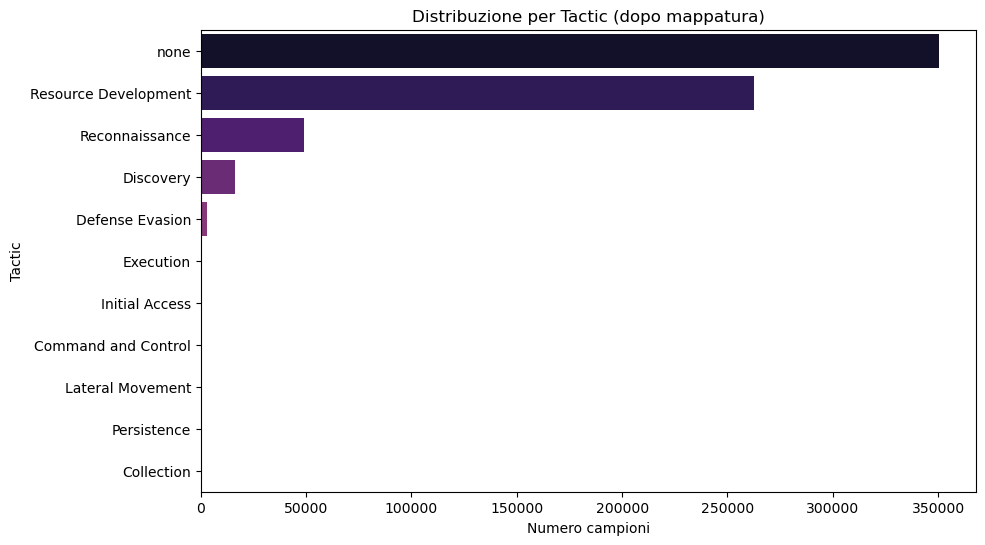


📝 Note pratiche:
- Se 'tactic' contiene 'Unknown', completa il CSV/dizionario di mapping prima dell'encoding.
- Esegui questa mappatura *prima* di encoding/scaling: la colonna 'tactic' deve essere convertita in numerico assieme alle altre categoriche.
- Puoi usare 'tactic' come label per classificazione multiclass oppure tenerla come feature aggiuntiva (dipende dal task).
- Se la distribuzione per tactic è estremamente sbilanciata, dovrai considerare tecniche di bilanciamento per il training (class weights, SMOTE, undersampling, ecc.).


In [12]:
# BLOCCO: Mappa technique -> tactic e riepilogo per tactic
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------- 1) Se label_tactic esiste già, usala -----------------
if 'label_tactic' in data.columns and data['label_tactic'].notna().any():
    print("✅ Colonna 'label_tactic' già presente: la useremo per il riepilogo.\n")
    data['tactic'] = data['label_tactic'].astype(str)
else:
    # -------------- 2) Altrimenti: proviamo a creare label 'tactic' --------------
    # a) se hai un file mapping CSV (technique -> tactic), caricalo
    #    formato atteso: columns ['technique_id','tactic']  (es. 'T1046','Discovery')
    mapping_csv_path = "mitre_technique_to_tactic.csv"   # cambia percorso se hai il file
    try:
        map_df = pd.read_csv(mapping_csv_path)
        # normalizziamo nomi colonne più comuni
        map_df.columns = [c.strip().lower() for c in map_df.columns]
        # proviamo a trovare le colonne giuste
        if 'technique_id' in map_df.columns and 'tactic' in map_df.columns:
            map_df = map_df[['technique_id','tactic']].dropna()
            map_dict = dict(zip(map_df['technique_id'].astype(str), map_df['tactic'].astype(str)))
            data['tactic'] = data['label_technique'].astype(str).map(map_dict).fillna('Unknown')
            print(f"✅ Usato mapping da CSV: {mapping_csv_path}")
        else:
            raise Exception("CSV non nel formato atteso (colonne technique_id,tactic).")
    except FileNotFoundError:
        # b) se non hai CSV: fallback a dizionario manuale (completa tu le voci importanti)
        print("ℹ️ File di mapping non trovato. Uso dizionario manuale ridotto (completa con i Txxxx che ti servono).")
        # ESEMPIO: inserisci qui i mapping che conosci. Non includo mappature MITRE non richieste.
        manual_map = {
            # 'T1046': 'Discovery',
            # 'T1587': 'Resource Development',
            # 'T1592': 'Resource Development',
            # 'T1590': 'Resource Development',
            # 'T1059': 'Execution',
            # 'T1190': 'Initial Access',
            # ...
        }
        data['tactic'] = data['label_technique'].astype(str).map(manual_map).fillna('Unknown')
        print("⚠️ Alcuni technique potrebbero risultare 'Unknown' finché non completi il dizionario o fornisci il CSV.")

# -------------- 3) Riepilogo counts + percentuali per tactic --------------
tactic_counts = data['tactic'].value_counts().sort_values(ascending=False)
tactic_percent = (tactic_counts / len(data) * 100).round(2)

tactic_df = pd.DataFrame({
    'Conteggio': tactic_counts,
    'Percentuale (%)': tactic_percent
})
print("\n🔹 Distribuzione per tactic (label_tactic / mappata):")
display(tactic_df)

# Plot orizzontale (più leggibile per tante categorie)
plt.figure(figsize=(10,6))
sns.barplot(y=tactic_counts.index, x=tactic_counts.values, palette='magma')
plt.title("Distribuzione per Tactic (dopo mappatura)")
plt.xlabel("Numero campioni")
plt.ylabel("Tactic")
plt.show()

# -------------- 4) Commenti pratici su pipeline ----------------
print("\n📝 Note pratiche:")
print("- Se 'tactic' contiene 'Unknown', completa il CSV/dizionario di mapping prima dell'encoding.")
print("- Esegui questa mappatura *prima* di encoding/scaling: la colonna 'tactic' deve essere convertita in numerico assieme alle altre categoriche.")
print("- Puoi usare 'tactic' come label per classificazione multiclass oppure tenerla come feature aggiuntiva (dipende dal task).")
print("- Se la distribuzione per tactic è estremamente sbilanciata, dovrai considerare tecniche di bilanciamento per il training (class weights, SMOTE, undersampling, ecc.).")
